In [27]:
import numpy as np

import os, sys

project_root = os.path.abspath('/Users/subhojit/workspace/saturn/src')
if project_root not in sys.path:
    sys.path.append(project_root)

from lstm.lstm_raw import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_names(filename):
    names = open(filename, 'r').read().splitlines()
    chars = sorted(list(set(''.join(names))))
    special_chars = ['<PAD>', '<SOS>', '<EOS>']
    all_chars = special_chars + chars
    stoi = {ch: i for i, ch in enumerate(all_chars)}
    itos = {i: ch for i, ch in enumerate(all_chars)}
    vocab_size = len(stoi)

    return stoi, itos, vocab_size, names

stoi, itos, vocab_size, names = load_names('indian_names.txt')
stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

In [23]:
def name_to_sequence(name, stoi):
    input_seq = ['<SOS>'] + list(name)
    output_seq = list(name) + ['<EOS>']

    input_idx = [stoi[ch] for ch in input_seq]
    output_idx = [stoi[ch] for ch in output_seq]

    return input_idx, output_idx

input_idx, output_idx = name_to_sequence(names[0], stoi)
input_idx, output_idx

([1, 3, 3, 4, 11, 6], [3, 3, 4, 11, 6, 2])

In [52]:
stoi, itos, vocab_size, names = load_names('indian_names.txt')
X_data, Y_data = zip(*[name_to_sequence(name, stoi) for name in names])
X_data[29], Y_data[29], [itos[i] for i in X_data[29]], [itos[i] for i in Y_data[29]]

([1, 3, 3, 15, 17, 21, 10],
 [3, 3, 15, 17, 21, 10, 2],
 ['<SOS>', 'a', 'a', 'm', 'o', 's', 'h'],
 ['a', 'a', 'm', 'o', 's', 'h', '<EOS>'])

In [39]:
# Re-define helper functions needed for training loop

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    return -np.log(y_pred[y_true, 0])

def cross_entropy_grad(y_pred, y_true):
    grad = y_pred.copy()
    grad[y_true] -= 1
    return grad

# Vectorized loss and gradient for full sequences
def vectorized_loss_and_gradient(outputs, y_true_seq):
    T = len(outputs)
    output_size = outputs[0][0].shape[0]

    Y_logits = np.stack([y[0] for y in outputs], axis=0)  # (T, output_size, 1)
    Y_logits_shifted = Y_logits - np.max(Y_logits, axis=1, keepdims=True)
    exp_scores = np.exp(Y_logits_shifted)
    Y_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    y_true_seq = np.array(y_true_seq)
    log_probs = -np.log(Y_probs[np.arange(T), y_true_seq, 0])
    total_loss = np.sum(log_probs)

    dY = Y_probs.copy()
    dY[np.arange(T), y_true_seq, 0] -= 1
    dy_list = [dY[t] for t in range(T)]

    return total_loss, dy_list


In [43]:
#training

input_size = vocab_size
hidden_size = 128
output_size = vocab_size
lossi = []

model = LSTMLayer(input_size, hidden_size, output_size)
lr = 0.01
epochs = 100

for epoch in range(epochs):
    total_loss = 0.0

    for xidx, yidx in zip(X_data, Y_data):
        loss = 0.0
        inputs = [np.eye(input_size)[:, i].reshape(-1, 1) for i in xidx]

        h0 = np.zeros((hidden_size, 1))
        c0 = np.zeros((hidden_size, 1))

        outputs = model.forward(inputs, h0, c0)
        loss, dy_list = vectorized_loss_and_gradient(outputs, yidx)
        total_loss += loss

        grads, dWy, dby = model.backward(dy_list)
        model.update_parameters(grads, dWy, dby, lr)

    lossi.append(total_loss)
    print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss:.4f}")


Epoch 1/100, Total Loss: 102226.0995
Epoch 2/100, Total Loss: 87569.5611
Epoch 3/100, Total Loss: 84005.3210
Epoch 4/100, Total Loss: 81523.7964
Epoch 5/100, Total Loss: 79386.1320
Epoch 6/100, Total Loss: 77948.4497
Epoch 7/100, Total Loss: 76480.9298
Epoch 8/100, Total Loss: 75112.6061
Epoch 9/100, Total Loss: 73861.0844
Epoch 10/100, Total Loss: 72755.7386
Epoch 11/100, Total Loss: 71705.6607
Epoch 12/100, Total Loss: 70656.8277
Epoch 13/100, Total Loss: 69747.4964
Epoch 14/100, Total Loss: 68965.4013
Epoch 15/100, Total Loss: 68053.0259
Epoch 16/100, Total Loss: 67154.2234
Epoch 17/100, Total Loss: 66254.0397
Epoch 18/100, Total Loss: 65505.1029
Epoch 19/100, Total Loss: 64829.7772
Epoch 20/100, Total Loss: 64216.5211
Epoch 21/100, Total Loss: 63577.6093
Epoch 22/100, Total Loss: 62946.4117
Epoch 23/100, Total Loss: 62374.6348
Epoch 24/100, Total Loss: 61784.2297
Epoch 25/100, Total Loss: 61149.8675
Epoch 26/100, Total Loss: 60466.8060
Epoch 27/100, Total Loss: 59830.0180
Epoch 28/

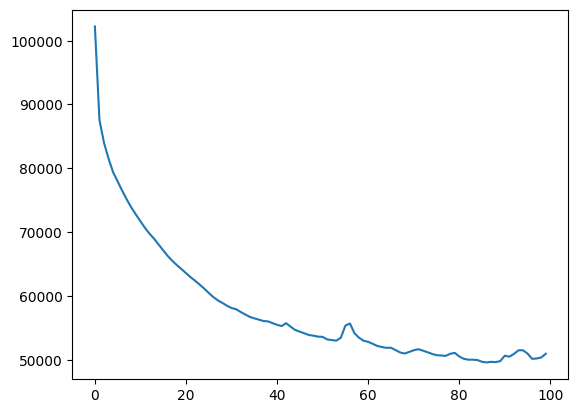

In [44]:
plt.plot(lossi)

In [72]:
def sample_name(max_length=20, temperature=2.0):
    start_char = '<SOS>'
    curr_index = stoi[start_char]

    h0 = np.zeros((hidden_size, 1))
    c0 = np.zeros((hidden_size, 1))

    generated_ch = []

    for i in range(max_length):
        input = np.eye(vocab_size)[:, curr_index].reshape(-1, 1)

        outputs = model.forward([input], h0, c0)
        yt, h, c = outputs[-1]
        logits = yt/temperature
        probs = softmax(logits)
        curr_index = np.random.choice(len(probs), p=probs.ravel())

        if itos[curr_index] == '<EOS>':
            break

        generated_ch.append(itos[curr_index])

    generated_name = ''.join(generated_ch)
    return generated_name

for _ in range(100):
    n = sample_name(max_length=20, temperature=6.0)
    print(n)


s
kmdp<SOS>girixoqegjyaudr
zyenqashaftay<SOS>trjzyf
honc
vlevrgoguiqjjkjjsy
xdufa
edifchbchrokameatov
ehifx<PAD>kjupmekzswesln
bkcvedshfvawiachukni
yoshqistagiku
delikomrbvatuvid
ttdkujmgmrveha
felbhinelpsiroyenqhq
craraahqarlyedaxoxns
jkijultwpmebadoyejny
khtrbbeqosrcimybhviw
vddimkiivetoevitilmr
yayujpncnypifibhowig
fkelzwab
zrusbefsbsmhbezampbz
mota<SOS>wevebeselrjgwgv
dhingreripeeazogva
pmqodyndufuyeratoya
yitbkbhnvonwakabyamn
ybim<PAD>izelnurirhsbroo
ixrtqohcena<SOS>vanopaqt
jlpebcarujwitrjbishi
umlektygndrachbnreri
zdrorbopixe<PAD>aazbaxrs
etfobyattt<PAD>elaficirw
wsurjdmkanhksbbyrbu
<SOS>ceifldrumcfworykowu
bobmkhtwdtrkiujvrbuz
gudp<SOS>kejothcbertrcdd
xm
vuspiyhhusussyowrchl
krob<SOS>zjpmiski
quzirbbya<SOS>rajgshenge
oznhyseq<PAD>tufuq<PAD>hter<PAD>
udismmezilund
wankazbifimqignkuxae
umiggi
wioku
lixb<SOS>wmadta
wausatinuetishlgidwe
sienkrfwgretkxvmukuk
rozku
vjooheutalueaypbfhfh
kehgetleliratq
shgetoranumjafgotice
sureggx
yiblednlpmiuvlso<PAD>oph
ygcynabhurkayk<SOS>zkchn
yeprm

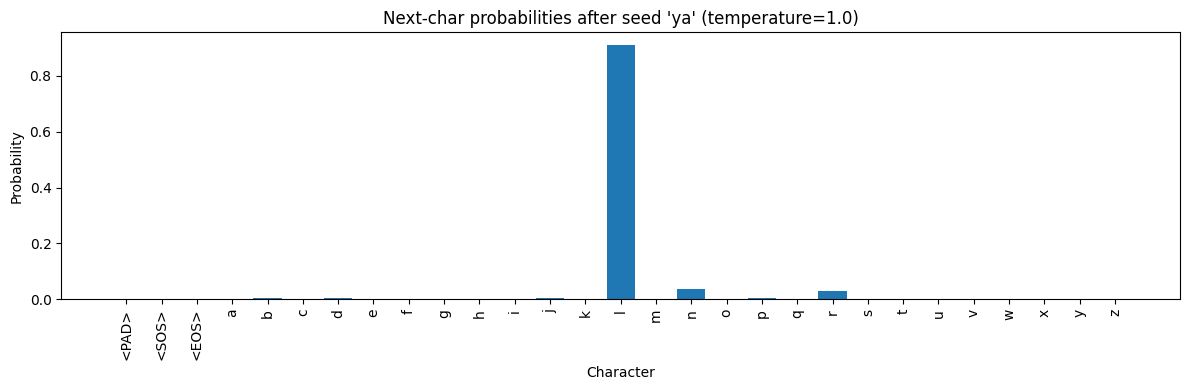

In [73]:
# Re-import everything needed after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# Softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

# Re-define plotting function
def plot_next_char_probs(model, seed_str, char2idx, idx2char, temperature=1.0):
    input_size = len(char2idx)
    hidden_size = model.hidden_size

    h = np.zeros((hidden_size, 1))
    c = np.zeros((hidden_size, 1))

    for ch in seed_str:
        idx = char2idx.get(ch, None)
        if idx is None:
            print(f"Character '{ch}' not in vocabulary.")
            return
        xt = np.eye(input_size)[:, idx].reshape(-1, 1)
        outputs = model.forward([xt], h, c)
        _, h, c = outputs[-1]

    # Predict next char
    logits, _, _ = model.forward([xt], h, c)[-1]
    probs = softmax(logits / temperature).ravel()

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(probs)), probs, tick_label=[idx2char[i] for i in range(len(probs))])
    plt.xticks(rotation=90)
    plt.title(f"Next-char probabilities after seed '{seed_str}' (temperature={temperature})")
    plt.ylabel("Probability")
    plt.xlabel("Character")
    plt.tight_layout()
    plt.show()


plot_next_char_probs(model, seed_str="ya", char2idx=stoi, idx2char=itos, temperature=1.0)


In [75]:
for temp in [0.7, 1.0, 1.5, 5.0]:
    print(f"\n--- Temperature: {temp} ---")
    for _ in range(5):
        print(sample_name(temperature=temp))


--- Temperature: 0.7 ---
zishanarununenudeeee
yashilotimiyanuleeee
yanuliraneeeeeenkuna
yanuditanulalititini
yanunkudimananishare

--- Temperature: 1.0 ---
yaranulimonishiyanit
yariyarunimubhimarar
yaranunudulomelimela
zinashisyanununirunu
ziraneeeeebitiswanee

--- Temperature: 1.5 ---
yashisunisafunalmeee
upunititindkumanimas
zatisweesweesoshayam
waberititamemanamala
vitisudhidhavalitaun

--- Temperature: 5.0 ---
vtnwethumdichukuneap
zmeelodindimhoarjuke
yobmeu<SOS>yximn
rjfifisanikhaomnuuha
wlunasooparillirjdo
